In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import random
#train_data = pd.read_csv('train.csv')
train_data = pd.read_csv('data/train.csv')

# Preprocessing (Update as per your dataset specifics)
train_data['TEXT'] = train_data['TITLE'] + ' ' + train_data['ABSTRACT']
X = train_data['TEXT']
y = train_data[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import random

# Load the dataset
#train_data = pd.read_csv('train.csv')
train_data = pd.read_csv('data/train.csv')
train_data['TEXT'] = train_data['TITLE'] + ' ' + train_data['ABSTRACT']

X = train_data['TEXT']
y = train_data[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']].values

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()

# Helper function to identify minority labels
def get_tail_labels(y):
    tail_labels = [i for i in range(y.shape[1]) if np.sum(y[:, i]) < (y.shape[0] / 2)]
    return tail_labels

# class distribution before applying dynamic MLSMOTE
print("Class distribution before applying dynamic MLSMOTE:")
for i, label in enumerate(['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']):
    print(f"{label}: {np.sum(y_train[:, i])}")

# Dynamic MLSMOTE function
def dynamic_MLSMOTE(X, y, target_balance=4500):
    n_neighbors = min(5, len(X) - 1)
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(X)
    tail_labels = get_tail_labels(y)
    synthetic_samples = []
    synthetic_labels = []

    for i in tail_labels:
        current_count = np.sum(y[:, i])
        n_samples = max(target_balance - current_count, 0)  # Calculate the number of samples to generate
        target_indices = np.where(y[:, i] == 1)[0]
        
        if len(target_indices) >= n_neighbors:
            nn = neigh.kneighbors(X[target_indices], return_distance=False)
            for _ in range(n_samples):
                sample_index = random.choice(range(len(target_indices)))
                nn_indices = nn[sample_index, 1:]
                chosen_nn = random.choice(nn_indices)
                step = np.random.rand()
                synthetic_sample = X[target_indices[sample_index]] + step * (X[chosen_nn] - X[target_indices[sample_index]])
                synthetic_samples.append(synthetic_sample)
                synthetic_label = y[target_indices[sample_index]].copy()
                synthetic_labels.append(synthetic_label)
    
    if len(synthetic_samples) > 0:
        X_synthetic = np.vstack(synthetic_samples)
        y_synthetic = np.vstack(synthetic_labels)
        X_balanced = np.vstack((X, X_synthetic))
        y_balanced = np.vstack((y, y_synthetic))
        return X_balanced, y_balanced
    else:
        return X, y

# Convert y_train to numpy array for processing
y_train_np = y_train

# Adjust this target balance
target_balance = 4500  
X_balanced_tfidf, y_balanced = dynamic_MLSMOTE(X_train_tfidf, y_train_np, target_balance=target_balance)

# class distribution after applying dynamic MLSMOTE
print("\n")
print("Class distribution after applying dynamic MLSMOTE:")
for i, label in enumerate(['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']):
    print(f"{label}: {np.sum(y_balanced[:, i])}")


Class distribution before applying dynamic MLSMOTE:
Computer Science: 6902
Physics: 4787
Mathematics: 4468
Statistics: 4137
Quantitative Biology: 465
Quantitative Finance: 204


Class distribution after applying dynamic MLSMOTE:
Computer Science: 7537
Physics: 4805
Mathematics: 4593
Statistics: 5774
Quantitative Biology: 4593
Quantitative Finance: 4534


In [5]:

# X_balanced_tfidf and y_balanced arebalanced datasets returned from dynamic_MLSMOTE
feature_names = vectorizer.get_feature_names_out()
df_features = pd.DataFrame(X_balanced_tfidf, columns=feature_names)
df_labels = pd.DataFrame(y_balanced, columns=['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance'])
df_balanced = pd.concat([df_features, df_labels], axis=1)


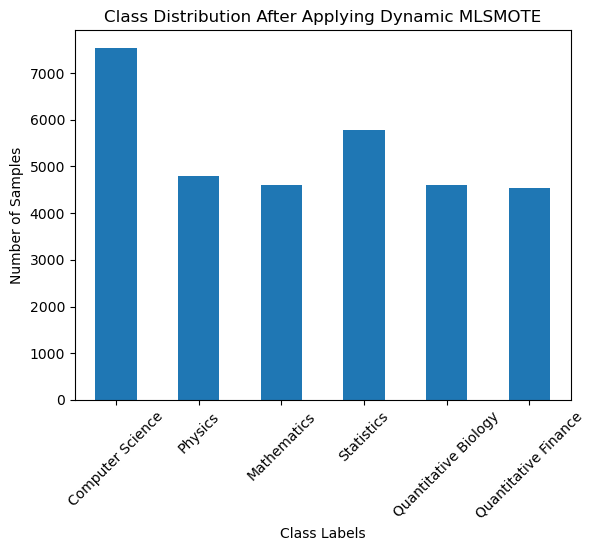

In [6]:
import matplotlib.pyplot as plt

label_sums = df_balanced.iloc[:, -6:].sum()
# bar plot for label distribution
label_sums.plot(kind='bar')
plt.title('Class Distribution After Applying Dynamic MLSMOTE')
plt.ylabel('Number of Samples')
plt.xlabel('Class Labels')
plt.xticks(rotation=45)
plt.show()


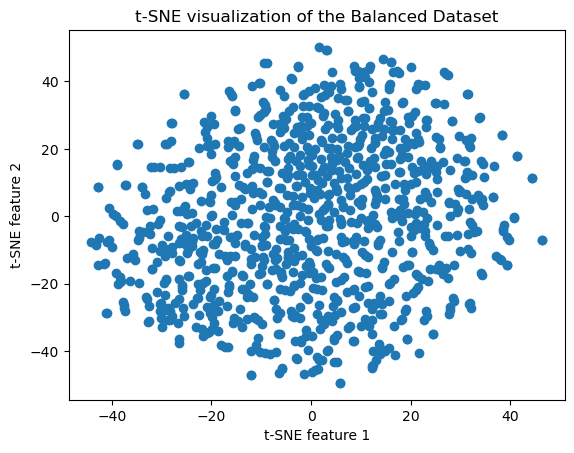

In [7]:
from sklearn.manifold import TSNE

#TSNE for dimensionality reduction to visualize high-dimensional data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_features.iloc[:1000])

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE visualization of the Balanced Dataset')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [8]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

X_test_tfidf = vectorizer.transform(X_val).toarray()
#train the model on the balanced dataset
model = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
model.fit(X_balanced_tfidf, y_balanced)  
y_pred = model.predict(X_val_tfidf) 

# Evaluate the model on the validation set
accuracy = accuracy_score(y_val, y_pred)  
f1 = f1_score(y_val, y_pred, average='micro')  

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')



Accuracy: 0.6222
F1 Score: 0.7798


In [9]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss
from scipy.stats import gmean
from sklearn.preprocessing import MultiLabelBinarizer

# Binarize the labels for metrics calculation
mlb = MultiLabelBinarizer()
y_val_binarized = mlb.fit_transform(y_val)

# Define and train models with transformation methods
transformations = {
    'Binary Relevance': BinaryRelevance,
    'Classifier Chains': ClassifierChain,
    'Label Powerset': LabelPowerset
}

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'MLkNN': MLkNN(k=3),
    'Decision Tree': DecisionTreeClassifier()
}

for transformation_name, Transformation in transformations.items():
    for model_name, model in models.items():
        if model_name != 'MLkNN':  # MLkNN requires sparse format
            classifier = Transformation(classifier=model)
            classifier.fit(X_balanced_tfidf, y_balanced)
            predictions = classifier.predict(X_val_tfidf)
            predictions = mlb.inverse_transform(predictions)
        else:
            classifier = model
            classifier.fit(X_balanced_tfidf, y_balanced)
            predictions = classifier.predict(X_val_tfidf)
            predictions = mlb.inverse_transform(predictions)
        
        # Calculate metrics
        y_pred_binarized = mlb.transform(predictions)
        accuracy = accuracy_score(y_val_binarized, y_pred_binarized)
        f1 = f1_score(y_val_binarized, y_pred_binarized, average='micro')
        precision = precision_score(y_val_binarized, y_pred_binarized, average='micro')
        recall = recall_score(y_val_binarized, y_pred_binarized, average='micro')
        gmean_val = gmean(y_val_binarized[y_val_binarized.sum(axis=1) != 0], y_pred_binarized[y_val_binarized.sum(axis=1) != 0], axis=None)  # Adjusted for binary relevance
        hamming = hamming_loss(y_val_binarized, y_pred_binarized)
        
        print(f"{transformation_name} with {model_name}: Accuracy: {accuracy}, F1: {f1}, Precision: {precision}, Recall: {recall}, G-mean: {gmean_val}, Hamming Loss: {hamming}")


ValueError: Expected indicator for 2 classes, but got 6